# YNet - Dataset 4.2:

Data from Experiment (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [17]:
PATH = "datasets/yeast_v4.2.1/"
data_path = Path(PATH)

In [18]:
CLASSES = ('WT', 'mfb1KO', 'mmr1KO','mmr1KO-mfb1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

Note that we are setting up train & val data, as well as test. Within test, we are here including a mutant cell type that the model never trains on. The idea is to use to the feature space developed during training to evaluate novel cell types by similarity to the landmarks that the model was trained on. 

In [19]:
# stats_name = "yeast_v10.2_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
test_ = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val)
test_stats = Statistics.per_class(test_)

working on: datasets\yeast_v4.2.1\train\02_mfb1KO
working on: datasets\yeast_v4.2.1\val\02_mfb1KO
working on: datasets\yeast_v4.2.1\train\02_mmr1KO
working on: datasets\yeast_v4.2.1\val\02_mmr1KO
working on: datasets\yeast_v4.2.1\train\02_mmr1KO-mfb1KO
working on: datasets\yeast_v4.2.1\val\02_mmr1KO-mfb1KO
working on: datasets\yeast_v4.2.1\train\02_WT
working on: datasets\yeast_v4.2.1\val\02_WT
working on: datasets\yeast_v4.2.1\test\01_mfb1KO
working on: datasets\yeast_v4.2.1\test\01_mmr1KO


In [20]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

02_mfb1KO: 	 	 	 (array([0.00794, 0.00476]), array([0.00073, 0.00156]))
02_mmr1KO: 	 	 	 (array([0.00797, 0.00482]), array([0.00075, 0.00169]))
02_mmr1KO-mfb1KO: 	 	 	 (array([0.0079 , 0.00474]), array([0.00073, 0.00153]))
02_WT: 	 	 	 (array([0.00796, 0.00474]), array([0.00074, 0.00146]))


In [21]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {test_stats[keys]}")

01_mfb1KO: 	 	 	 (array([0.02112, 0.00447]), array([0.00145, 0.00144]))
01_mmr1KO: 	 	 	 (array([0.02116, 0.00486]), array([0.00156, 0.00197]))


## Defining datasets:

In [22]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [23]:
def get_data(path: str, sz, bs):
    create, lbl2index, lbl2index_test = ImageClassifierData.prepare_from_path(path, val_name='val', bs=bs, num_workers=1,
                                                                             test_name='test', test_with_labels=True)
    
    main_stats_X = {lbl2index[key][0]: val for key, val in main_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8)
    
    test_stats_X = {lbl2index_test[key][0]: val for key, val in test_stats.items()}
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    
#     print(main_stats_X)
#     print(test_stats_X)
    
    print('\n class to index mapping:\n',lbl2index)
    print('\n class to index mapping:\n',lbl2index_test)
    return create(tfms)

In [24]:
data = get_data(PATH,SIZE,BATCH_SIZE)


 class to index mapping:
 {'02_WT': [0, 0, 'WT'], '02_mfb1KO': [1, 1, 'mfb1KO'], '02_mmr1KO': [2, 2, 'mmr1KO'], '02_mmr1KO-mfb1KO': [3, 3, 'mmr1KO-mfb1KO']}

 class to index mapping:
 {'01_mfb1KO': [0, 0, 'mfb1KO'], '01_mmr1KO': [1, 1, 'mmr1KO']}


In [11]:
x, y = next(iter(data.trn_dl))

In [ ]:
x, y = next(iter(data.test_dl))

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
# print(y)

### Inspect loaded data:

Displaying the same image with and without normalization.

In [ ]:
# specify which image-index
idx = 6

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

# Training setup

In [12]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

Defining network architecture. 

In [25]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [26]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [27]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [28]:
wd=1e-5 # weight-decay/L2 regularization 

In [29]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [ ]:
learn.summary()

In [30]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 5                                                                                                                                                              
mean: [26.33333 25.11111 34.66667 12.     ]
stdev: [5.51765 4.12161 3.71184 4.34613]

[WT]: 100.0%
[mfb1KO]:  0.0%
[mmr1KO]:  0.0%
[mmr1KO-mfb1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      20.372727  15.888613  0.25      
EPOCH 1 ---------------------------------------- STEP 6                                                                                                                                                              
mean: [26.44444 25.      34.66667 11.88889]
stdev: [6.75131 3.68179 7.87401 3.44624]

[WT]:  0.0%
[mfb1KO]:  0.0%
[mmr1KO]: 100.0%
[mmr1KO-mfb1KO]:  0.0%
    1      23.672109  21.576395  0.25      
EPOCH 2 ---------------------------------------- STEP 7                                                                            

[array([4.2644]), 0.2571428571428571]

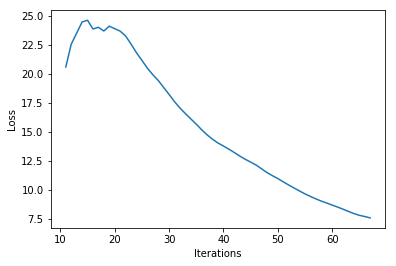

In [31]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

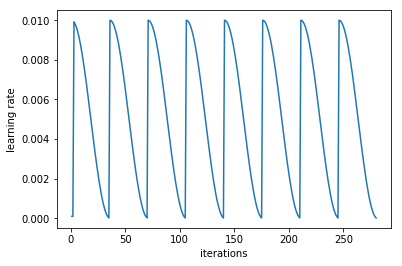

In [20]:
learn.sched.plot_lr()

#### Run some more cylces - error & accuracy should continuously improve

Note: cycle len = number of epochs per cycle

In [32]:
%time learn.fit(1e-2, 10, wds=wd, cycle_len=2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 13                                                                                                                                                             
mean: [26.22222 25.22222 34.66667 11.77778]
stdev: [2.89742 3.67507 5.84998 5.73058]

[WT]:  0.0%
[mfb1KO]:  0.0%
[mmr1KO]: 100.0%
[mmr1KO-mfb1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      2.383258   1.656973   0.25      
EPOCH 1 ---------------------------------------- STEP 14                                                                                                                                                             
mean: [26.33333 25.22222 34.88889 11.77778]
stdev: [4.24264 6.56214 7.73799 4.26296]

[WT]: 17.14%
[mfb1KO]: 11.43%
[mmr1KO]: 77.14%
[mmr1KO-mfb1KO]: 45.71%
    1      1.905252   1.342755   0.378571  
EPOCH 2 ---------------------------------------- STEP 15                                                                        


[WT]: 82.86%
[mfb1KO]: 60.0%
[mmr1KO]: 57.14%
[mmr1KO-mfb1KO]: 14.29%
    19     1.083865   1.086679   0.535714  
Wall time: 1min 51s


[array([1.08668]), 0.5357142859271594]

In [33]:
%time learn.fit(1e-3, 10, wds=wd, cycle_len=2, cycle_mult = 2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 33                                                                                                                                                             
mean: [26.33333 25.33333 34.88889 11.88889]
stdev: [4.37163 3.97213 4.48316 2.72619]

[WT]: 88.57%
[mfb1KO]: 65.71%
[mmr1KO]: 60.0%
[mmr1KO-mfb1KO]: 8.571%
epoch      trn_loss   val_loss   accuracy   
    0      0.984665   1.078071   0.557143  
EPOCH 1 ---------------------------------------- STEP 34                                                                                                                                                             
mean: [26.44444 25.11111 34.66667 11.88889]
stdev: [4.05822 6.50546 6.39444 3.92837]

[WT]: 85.71%
[mfb1KO]: 40.0%
[mmr1KO]: 74.29%
[mmr1KO-mfb1KO]: 2.857%
    1      0.986695   1.154332   0.507143  
EPOCH 2 ---------------------------------------- STEP 35                                                                       


[WT]: 80.0%
[mfb1KO]: 62.86%
[mmr1KO]: 68.57%
[mmr1KO-mfb1KO]: 8.571%
    19     0.954487   1.07497    0.55      
EPOCH 20 ---------------------------------------- STEP 53                                                                                                                                                            
mean: [26.33333 25.22222 34.66667 11.88889]
stdev: [4.6188  4.1574  5.33333 4.72451]

[WT]: 80.0%
[mfb1KO]: 57.14%
[mmr1KO]: 71.43%
[mmr1KO-mfb1KO]: 8.571%
    20     0.953652   1.067609   0.542857  
EPOCH 21 ---------------------------------------- STEP 54                                                                                                                                                            
mean: [26.33333 25.11111 34.55556 11.88889]
stdev: [5.90668 5.06501 7.70442 2.23331]

[WT]: 91.43%
[mfb1KO]: 57.14%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 5.714%
    21     0.950277   1.081872   0.542857  
EPOCH 22 ---------------------------------------- STEP 5

EPOCH 39 ---------------------------------------- STEP 72                                                                                                                                                            
mean: [26.33333 25.22222 34.66667 11.88889]
stdev: [2.94392 4.31478 4.08248 2.92288]

[WT]: 91.43%
[mfb1KO]: 60.0%
[mmr1KO]: 60.0%
[mmr1KO-mfb1KO]: 5.714%
    39     0.934822   1.074138   0.542857  
EPOCH 40 ---------------------------------------- STEP 73                                                                                                                                                            
mean: [26.44444 25.22222 34.77778 11.88889]
stdev: [6.49976 5.49298 5.26578 3.72512]

[WT]: 88.57%
[mfb1KO]: 68.57%
[mmr1KO]: 71.43%
[mmr1KO-mfb1KO]: 5.714%
    40     0.934102   1.049998   0.585714  
EPOCH 41 ---------------------------------------- STEP 74                                                                                                                   

[mfb1KO]: 62.86%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 8.571%
    58     0.907546   1.082871   0.55      
EPOCH 59 ---------------------------------------- STEP 92                                                                                                                                                            
mean: [26.44444 25.11111 34.66667 11.77778]
stdev: [5.12317 6.48836 4.57044 4.84832]

[WT]: 85.71%
[mfb1KO]: 62.86%
[mmr1KO]: 68.57%
[mmr1KO-mfb1KO]: 11.43%
    59     0.905257   1.03953    0.571429  
EPOCH 60 ---------------------------------------- STEP 93                                                                                                                                                            
mean: [26.44444 25.      34.77778 11.66667]
stdev: [5.33565 4.10961 4.46661 4.16333]

[WT]: 88.57%
[mfb1KO]: 68.57%
[mmr1KO]: 57.14%
[mmr1KO-mfb1KO]: 14.29%
    60     0.902076   1.014652   0.571429  
EPOCH 61 ---------------------------------------- STEP 94           


[WT]: 88.57%
[mfb1KO]: 57.14%
[mmr1KO]: 82.86%
[mmr1KO-mfb1KO]: 14.29%
    78     0.890121   1.051402   0.607143  
EPOCH 79 ---------------------------------------- STEP 112                                                                                                                                                           
mean: [26.44444 25.      34.77778 11.88889]
stdev: [5.96492 5.03322 5.97732 3.21263]

[WT]: 94.29%
[mfb1KO]: 62.86%
[mmr1KO]: 54.29%
[mmr1KO-mfb1KO]: 8.571%
    79     0.887313   1.110628   0.55      
EPOCH 80 ---------------------------------------- STEP 113                                                                                                                                                           
mean: [26.44444 25.11111 34.88889 11.77778]
stdev: [4.76354 6.57342 4.58123 4.39135]

[WT]: 77.14%
[mfb1KO]: 68.57%
[mmr1KO]: 57.14%
[mmr1KO-mfb1KO]: 8.571%
    80     0.882529   1.011491   0.528571  
EPOCH 81 ---------------------------------------- STEP

EPOCH 98 ---------------------------------------- STEP 131                                                                                                                                                           
mean: [26.33333 25.22222 34.66667 11.77778]
stdev: [5.12076 4.46661 8.05536 4.41658]

[WT]: 88.57%
[mfb1KO]: 68.57%
[mmr1KO]: 57.14%
[mmr1KO-mfb1KO]: 5.714%
    98     0.865458   1.037587   0.55      
EPOCH 99 ---------------------------------------- STEP 132                                                                                                                                                           
mean: [26.44444 25.      34.66667 11.88889]
stdev: [5.90877 5.88784 5.53775 3.41384]

[WT]: 82.86%
[mfb1KO]: 71.43%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 20.0%
    99     0.865519   0.991823   0.592857  
EPOCH 100 ---------------------------------------- STEP 133                                                                                                                

[mfb1KO]: 62.86%
[mmr1KO]: 74.29%
[mmr1KO-mfb1KO]: 20.0%
   117     0.846433   0.976784   0.592857  
EPOCH 118 ---------------------------------------- STEP 151                                                                                                                                                          
mean: [26.33333 25.11111 34.77778 12.     ]
stdev: [5.31246 5.66558 5.15919 5.24934]

[WT]: 88.57%
[mfb1KO]: 65.71%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 20.0%
   118     0.846398   0.992272   0.592857  
EPOCH 119 ---------------------------------------- STEP 152                                                                                                                                                          
mean: [26.33333 25.22222 34.77778 11.88889]
stdev: [4.37163 4.73234 5.37024 4.14848]

[WT]: 77.14%
[mfb1KO]: 68.57%
[mmr1KO]: 60.0%
[mmr1KO-mfb1KO]: 25.71%
   119     0.842394   0.973459   0.578571  
EPOCH 120 ---------------------------------------- STEP 153            


[WT]: 82.86%
[mfb1KO]: 77.14%
[mmr1KO]: 51.43%
[mmr1KO-mfb1KO]: 28.57%
   137     0.831792   0.954425   0.6       
EPOCH 138 ---------------------------------------- STEP 171                                                                                                                                                          
mean: [26.44444 25.11111 34.66667 12.11111]
stdev: [5.69817 6.45402 4.59468 4.81766]

[WT]: 80.0%
[mfb1KO]: 71.43%
[mmr1KO]: 80.0%
[mmr1KO-mfb1KO]: 17.14%
   138     0.831142   0.990542   0.621429  
EPOCH 139 ---------------------------------------- STEP 172                                                                                                                                                          
mean: [26.22222 25.11111 34.66667 11.77778]
stdev: [5.41146 4.81766 7.07107 4.1036 ]

[WT]: 82.86%
[mfb1KO]: 65.71%
[mmr1KO]: 71.43%
[mmr1KO-mfb1KO]: 14.29%
   139     0.829724   0.999415   0.585714  
EPOCH 140 ---------------------------------------- STEP 

EPOCH 157 ---------------------------------------- STEP 190                                                                                                                                                          
mean: [26.33333 25.22222 34.88889 11.88889]
stdev: [6.09189 5.28683 5.74349 3.66498]

[WT]: 88.57%
[mfb1KO]: 57.14%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 8.571%
   157     0.802712   1.042598   0.542857  
EPOCH 158 ---------------------------------------- STEP 191                                                                                                                                                          
mean: [26.55556 25.33333 34.66667 11.88889]
stdev: [2.45452 5.2915  4.83046 3.21263]

[WT]: 85.71%
[mfb1KO]: 65.71%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 20.0%
   158     0.800098   1.007399   0.585714  
EPOCH 159 ---------------------------------------- STEP 192                                                                                                                

[mfb1KO]: 85.71%
[mmr1KO]: 54.29%
[mmr1KO-mfb1KO]: 25.71%
   176     0.768453   0.930424   0.628571  
EPOCH 177 ---------------------------------------- STEP 210                                                                                                                                                          
mean: [26.22222 25.22222 34.55556 12.     ]
stdev: [5.61304 4.89394 5.87104 4.57044]

[WT]: 91.43%
[mfb1KO]: 62.86%
[mmr1KO]: 65.71%
[mmr1KO-mfb1KO]: 5.714%
   177     0.770155   1.072709   0.564286  
EPOCH 178 ---------------------------------------- STEP 211                                                                                                                                                          
mean: [26.33333 25.33333 34.88889 11.88889]
stdev: [5.73488 4.16333 5.34258 2.92288]

[WT]: 82.86%
[mfb1KO]: 74.29%
[mmr1KO]: 65.71%
[mmr1KO-mfb1KO]: 25.71%
   178     0.770957   0.924806   0.621429  
EPOCH 179 ---------------------------------------- STEP 212         

KeyboardInterrupt: 

In [34]:
%time learn.fit(1e-5, 10, wds=wd, cycle_len=2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 213                                                                                                                                                            
mean: [26.33333 25.22222 34.66667 11.77778]
stdev: [5.39547 4.96158 4.94413 2.85882]

[WT]: 85.71%
[mfb1KO]: 68.57%
[mmr1KO]: 65.71%
[mmr1KO-mfb1KO]: 25.71%
epoch      trn_loss   val_loss   accuracy   
    0      0.755231   0.933741   0.614286  
EPOCH 1 ---------------------------------------- STEP 214                                                                                                                                                            
mean: [26.44444 25.11111 34.55556 11.88889]
stdev: [5.12317 3.81356 4.85595 4.14848]

[WT]: 94.29%
[mfb1KO]: 60.0%
[mmr1KO]: 65.71%
[mmr1KO-mfb1KO]: 17.14%
    1      0.769664   1.034185   0.592857  
EPOCH 2 ---------------------------------------- STEP 215                                                                     


[WT]: 82.86%
[mfb1KO]: 80.0%
[mmr1KO]: 68.57%
[mmr1KO-mfb1KO]: 22.86%
    19     0.759562   0.936636   0.635714  
Wall time: 2min 56s


[array([0.93664]), 0.6357142857142857]

In [35]:
%time learn.fit(1e-5, 5, wds=wd, cycle_len=2, cycle_mult=2, use_clr=(20,8, 0.95, 0.85))

EPOCH 0 ---------------------------------------- STEP 233                                                                                                                                                            
mean: [26.33333 25.11111 34.77778 11.88889]
stdev: [2.82843 6.62394 4.44167 5.06501]

[WT]: 88.57%
[mfb1KO]: 68.57%
[mmr1KO]: 68.57%
[mmr1KO-mfb1KO]: 17.14%
epoch      trn_loss   val_loss   accuracy   
    0      0.794019   0.944053   0.607143  
EPOCH 1 ---------------------------------------- STEP 234                                                                                                                                                            
mean: [26.55556 25.11111 34.77778 11.88889]
stdev: [5.92755 5.06501 5.47272 2.33069]

[WT]: 71.43%
[mfb1KO]: 80.0%
[mmr1KO]: 74.29%
[mmr1KO-mfb1KO]: 31.43%
    1      0.780064   0.913023   0.642857  
EPOCH 2 ---------------------------------------- STEP 235                                                                     


[WT]: 82.86%
[mfb1KO]: 71.43%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 25.71%
    19     0.761147   0.941642   0.607143  
EPOCH 20 ---------------------------------------- STEP 253                                                                                                                                                           
mean: [26.33333 24.88889 34.55556 11.88889]
stdev: [5.53775 5.06501 4.99135 4.14848]

[WT]: 82.86%
[mfb1KO]: 68.57%
[mmr1KO]: 74.29%
[mmr1KO-mfb1KO]: 20.0%
    20     0.760671   0.974768   0.614286  
EPOCH 21 ---------------------------------------- STEP 254                                                                                                                                                           
mean: [26.33333 25.      34.55556 11.88889]
stdev: [4.24264 6.46357 3.2356  4.03992]

[WT]: 82.86%
[mfb1KO]: 60.0%
[mmr1KO]: 74.29%
[mmr1KO-mfb1KO]: 14.29%
    21     0.763106   0.978743   0.578571  
EPOCH 22 ---------------------------------------- STEP 2

EPOCH 39 ---------------------------------------- STEP 272                                                                                                                                                           
mean: [26.33333 25.22222 34.66667 11.77778]
stdev: [5.16398 5.24463 5.03322 2.24983]

[WT]: 77.14%
[mfb1KO]: 77.14%
[mmr1KO]: 77.14%
[mmr1KO-mfb1KO]: 17.14%
    39     0.757712   0.937869   0.621429  
EPOCH 40 ---------------------------------------- STEP 273                                                                                                                                                           
mean: [26.33333 25.22222 34.77778 11.77778]
stdev: [6.48074 5.28683 5.74993 4.18404]

[WT]: 85.71%
[mfb1KO]: 65.71%
[mmr1KO]: 74.29%
[mmr1KO-mfb1KO]: 22.86%
    40     0.755457   0.96577    0.621429  
EPOCH 41 ---------------------------------------- STEP 274                                                                                                                

[mfb1KO]: 68.57%
[mmr1KO]: 65.71%
[mmr1KO-mfb1KO]: 25.71%
    58     0.758455   0.961179   0.614286  
EPOCH 59 ---------------------------------------- STEP 292                                                                                                                                                           
mean: [26.33333 25.      34.66667 11.66667]
stdev: [5.7735 4.6188 4.2947 4.2947]

[WT]: 85.71%
[mfb1KO]: 68.57%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 31.43%
    59     0.758924   0.931921   0.621429  
EPOCH 60 ---------------------------------------- STEP 293                                                                                                                                                           
mean: [26.44444 25.      34.66667 11.88889]
stdev: [2.94811 4.37163 3.62093 2.80652]

[WT]: 88.57%
[mfb1KO]: 71.43%
[mmr1KO]: 62.86%
[mmr1KO-mfb1KO]: 20.0%
    60     0.758901   0.938401   0.607143  
EPOCH 61 ---------------------------------------- STEP 294               

[array([0.92139]), 0.6214285705770765]

## Analysis/Model evaluation

This is one of the major areas that needs improvement in our workflow. The tools we have so far (confusion matrix and manual inpsection of images) are essential but definitely not sufficient to ensure that our model learns something biologicaly relevant. Ideas are welcome!

### ...after training 

In [36]:
learn.save('YNet_Res_v4.2.1')

In [ ]:
## Load model:
learn.load('YNet_Res_v10.1')

In [ ]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

In [ ]:
learn.warm_up(1e-10)

In [37]:
log_preds, y = learn.TTA(n_aug=4) # run predictions with TTA

### Confusion matrix

[[28  0  4  3]
 [ 0 27  4  6]
 [ 5  5 27 17]
 [ 2  3  0  9]]


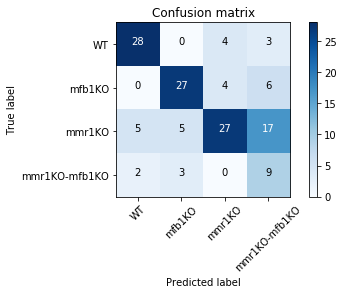

In [38]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

### Test-set eval

In [ ]:
test_learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), test_data)

In [ ]:
# learn.load('YNet_Res_v10.1')

In [ ]:
data = get_data(PATH,SIZE,BATCH_SIZE)

In [ ]:
tx, ty = next(test_batch)
print(ty)

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)

In [ ]:
s1a, s2a = next(batch_)

In [ ]:
batch2x = np.concatenate((s1.cpu().numpy().copy(), s1a.cpu().numpy().copy()), axis = 0)
print(batch2x.shape)

In [ ]:
ims = None
lbls = None

for b in range(0,len(dl)):
    x_, y_ = next(batch_)
    
    x_np = x.cpu().numpy().copy()
    y_np = y.cpu().numpy().copy()
    
    if ims is None:
        ims = x_np
        lbls = y_np
    else:
        ims = np.concatenate((ims, x_np), axis = 0)
        lbls = np.concatenate((lbls, y_np), axis = 0)

In [ ]:
dl_ = data.trn_dl
batch_ = iter(dl_)


plt.style.use('seaborn-whitegrid')
fig = plt.figure()
ax = plt.subplot(111)

for b in range(0,len(dl)):
    x_, y_ = next(batch_)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C0' , alpha=0.5)
        
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
dl_t = data.test_dl
batch_t = iter(dl_t)

ax = plt.subplot(111)

for b in range(0,len(dl_t)):
    x_, y_ = next(batch_t)

    x_np = to_np(x_)
    y_np = to_np(y_)
    
    im_means = np.mean(x_np, axis=(2,3))
    
    ax.plot(im_means[:,0], im_means[:,1], 'o', color = 'C1' , alpha=0.5)
    
plt.xlim(-0.4,0.4)
plt.ylim(-1, 4)

In [ ]:
# specify which image-index
idx = 60

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
# figure, _ ,_ = plt.imshow(np.sum(xx, axis=0))

# figure.set_size_inches(6,6)
# figure.add_subplot(111)

# figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2)) # not very elegant atm. 
# figure2.set_size_inches(6,6)
print(yy)

In [ ]:
tiff.imshow(data.test_ds[1][0][0,:,:])


In [41]:
data = get_data(PATH,SIZE,BATCH_SIZE)


 class to index mapping:
 {'02_WT': [0, 0, 'WT'], '02_mfb1KO': [1, 1, 'mfb1KO'], '02_mmr1KO': [2, 2, 'mmr1KO'], '02_mmr1KO-mfb1KO': [3, 3, 'mmr1KO-mfb1KO']}

 class to index mapping:
 {'01_mfb1KO': [0, 0, 'mfb1KO'], '01_mmr1KO': [1, 1, 'mmr1KO']}


In [56]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
print(len(data.test_dl.dataset.y))

350
2228
812


In [39]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)

In [40]:
print(preds)
print(targs)

[1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 1 1 3 1 2 1 1 1 1 1 0 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2
 2 2 2 2 2 2 3 0 2 1 0 2 1 2 2 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [59]:
data.classes

['WT', 'mfb1KO', 'mmm1KO', 'mmr1KO', 'num1KO', 'H2O2', 'dnm1KO', 'fzo1KO']

[[ 64  14   4  34   5   0   4  91]
 [118   6   5  23  40  12  96  12]
 [140   6   4  20  21   9  30  54]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


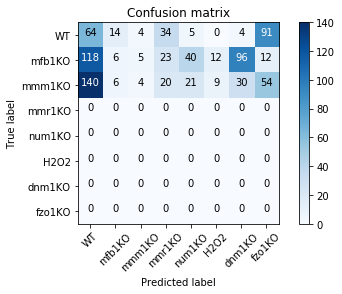

In [61]:
cm = confusion_matrix(targs,preds)
plot_confusion_matrix(cm, data.classes)

In [29]:
_, lbl2idx_, test_lbl2idx_ = ImageClassifierData.prepare_from_path(PATH, val_name='val', bs=64, num_workers=1,
                                                                             test_name='test', test_with_labels=True)

In [45]:
print(lbl2idx_)
print(test_lbl2idx_)

{'01_WT': [0, 0, 'WT'], '01_mfb1KO': [1, 1, 'mfb1KO'], '01_mmm1KO': [2, 2, 'mmm1KO'], '01_mmr1KO': [3, 3, 'mmr1KO'], '01_num1KO': [4, 4, 'num1KO'], '02_WT': [5, 0, 'WT'], '03_H2O2': [6, 5, 'H2O2'], '03_WT': [7, 0, 'WT'], '03_dnm1KO': [8, 6, 'dnm1KO'], '03_fzo1KO': [9, 7, 'fzo1KO']}
{'02_mfb1KO': [0, 0, 'mfb1KO'], '02_mmr1KO': [1, 1, 'mmr1KO'], '02_mmr1KO-mfb1KO': [2, 2, 'mmr1KO-mfb1KO']}


In [32]:
uIdx2uCls = {lbl2idx_[key][1]: lbl2idx_[key][2] for key in lbl2idx_.keys()}
test_uIdx2uCls = {test_lbl2idx_[key][1]: test_lbl2idx_[key][2] for key in test_lbl2idx_.keys()}

In [47]:
print(uIdx2uCls)
print(test_uIdx2uCls)

{0: 'WT', 1: 'mfb1KO', 2: 'mmm1KO', 3: 'mmr1KO', 4: 'num1KO', 5: 'H2O2', 6: 'dnm1KO', 7: 'fzo1KO'}
{0: 'mfb1KO', 1: 'mmr1KO', 2: 'mmr1KO-mfb1KO'}


In [50]:
vrb_preds = [uIdx2uCls[preds[i]] for i, _ in enumerate(preds)]
verb_targs = [test_uIdx2uCls[targs[i]] for i, _ in enumerate(targs)]

In [52]:
print(vrb_preds)
# print(verb_targs)

['WT', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmr1KO', 'WT', 'WT', 'WT', 'fzo1KO', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'WT', 'fzo1KO', 'mmr1KO', 'mfb1KO', 'WT', 'WT', 'WT', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'dnm1KO', 'fzo1KO', 'WT', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'WT', 'num1KO', 'fzo1KO', 'fzo1KO', 'mfb1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'fzo1KO', 'WT', 'mmr1KO', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'WT', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmr1KO', 'mmr1KO', 'WT', 'WT', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmm1KO', 'mmm1KO', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mmr1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'mmr1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'fzo1KO', 'WT', 'mfb1KO', 'mmr1KO', 'WT', 'fzo1KO', 'fzo1KO

In [ ]:
test_log_preds[188:220]

### Analyse images 

#### Show random correct/incorrectly classified images:

In [ ]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [ ]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [ ]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [ ]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

In [ ]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

In [ ]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [ ]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

In [ ]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")